In [1]:
import logging
import sys
import os

In [2]:
# TODO: estimate NN thresholds on model validation phase!

In [3]:
DEBUG = False
DISABLE_GPU = True


In [4]:
# if 'USE_CONTROL_SET' not in globals():
#     USE_CONTROL_SET = os.environ.get('GPN_USE_CONTROL_SET', 0) == '1'

USE_CONTROL_SET = True

if 'COLLECTION_NAME' not in globals():
    COLLECTION_NAME = 'documents'
    
print (f'{COLLECTION_NAME=}')
print (f'{USE_CONTROL_SET=}')

COLLECTION_NAME='documents'
USE_CONTROL_SET=True


In [5]:

# DISABLE GPU
if DISABLE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(f'{DISABLE_GPU=}')

DISABLE_GPU=True


In [6]:

logger = logging.getLogger('eval_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - [%(filename)s:%(lineno)d] - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.info('--=logging started=--')

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
  sys.path.append(nb_dir)

import analyser.hyperparams

INFO - 2023-04-26 16:34:03,466 - [2159728996.py:10] - eval_ipynb - --=logging started=--


Nemoware Analyser v23.4.14
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


In [7]:
import mlflow
print('mlflow.active_run', mlflow.active_run())

mlflow.active_run None


In [ ]:
import gpn_config

In [ ]:
sub_mlflow_run = None
if mlflow.active_run() is None:

    ml_flow_url = gpn_config.configured ('MLFLOW_URL')
    mlflow.set_tracking_uri(ml_flow_url)
    logger.warn(f'set MLFLOW_URL env var to re-define; MLFLOW_URL={ml_flow_url}')

    mlflow.set_experiment("Обучение анализатора")
    sub_mlflow_run = mlflow.start_run(nested=True)
 
    print('sub_mlflow_run', sub_mlflow_run)
    
mlflow.set_tag("release.version", analyser.__version__)
mlflow.set_tag("test_db_collection", COLLECTION_NAME)


/tmp/ipykernel_3171932/3089433087.py:6: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f'set MLFLOW_URL env var to re-define; MLFLOW_URL={ml_flow_url}')
WARNING - 2023-04-26 16:34:03,810 - [3089433087.py:6] - eval_ipynb - set MLFLOW_URL env var to re-define; MLFLOW_URL=http://192.168.10.38:5000


sub_mlflow_run <ActiveRun: >


### Imports

In [9]:
%matplotlib inline

from pathlib import Path
 
import numpy as np
import pandas as pd
from pandas import DataFrame

import json
import re

from bson import json_util
from bson import ObjectId

import traceback


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from analyser.schemas import ContractPrice, merge_spans
from integration.db import get_doc_by_id
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.parsing import AuditContext
from analyser.persistence import DbJsonDoc
from analyser.legal_docs import find_value_sign
from analyser.transaction_values import ValueSpansFinder
from analyser.text_tools import to_float, span_len

from analyser.contract_parser import nn_get_tag_values, nn_find_contract_value
from analyser.contract_parser import nn_find_org_names, nn_get_subject, nn_get_contract_number, nn_get_contract_date
from analyser.contract_parser import fix_contract_number

from analyser.persistence import DbJsonDoc

from tf_support.tools import KerasTrainingContext
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.super_contract_model import make_xyw, semantic_map_keys_contract
from tf_support.super_contract_model import validate_datapoint

from integration.db import get_doc_by_id
from integration.db import get_mongodb_connection

from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from colab_support.renderer import plot_embedding, plot_cm
from colab_support.renderer import HtmlRenderer

from IPython.display import display, HTML, Markdown

from tf_support.super_contract_model import t_semantic_map_keys_price, semantic_map_keys, t_semantic_map_keys_common, t_semantic_map_keys_org


semantic_keys_numeric = ['amount', 'amount_brutto', 'amount_netto']
org_keys=['name', 'alias', 'type']
org_numbered_keys=[ f'org-1-{v}' for v in org_keys]
org_numbered_keys+=[ f'org-2-{v}' for v in org_keys]
org_numbered_keys

2023-04-26 16:34:04.241335: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[documents.py:271 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:28 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


['org-1-name',
 'org-1-alias',
 'org-1-type',
 'org-2-name',
 'org-2-alias',
 'org-2-type']

In [10]:
class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()

# Prepare paths


In [11]:


work_dir = Path(analyser.hyperparams.work_dir)
training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

print(f'{training_reports_path=}')
print(f'{analyser.hyperparams.work_dir=}')
print(f'{work_dir=}')

training_reports_path=PosixPath('/root/artem/analyser/training_reports')
analyser.hyperparams.work_dir='/root/artem/work'
work_dir=PosixPath('/root/artem/work')


In [12]:
t_semantic_map_keys_price

['amount',
 'amount_brutto',
 'amount_netto',
 'vat',
 'sign',
 'currency',
 'vat_unit']

# Loading control test set from DB

In [13]:

from bson import ObjectId

def doc_as_table_row(jd:DbJsonDoc, df, col_suffix='_expected'):
    _id = str(jd._id)
    tree = jd.get_attributes_tree()
    df.at[ _id, f'number{col_suffix}'] = jd.get_attribute_value('number')
    df.at[ _id, f'date{col_suffix}']   = jd.get_attribute_value('date')
    df.at[ _id, f'subject{col_suffix}']= jd.get_attribute_value('subject')
    df.at[ _id, 'subject']= jd.get_attribute_value('subject')

    orgs = tree.get('orgs', [])

    if len(orgs)>0:
        o1=orgs[0]
    else:
        o1={}

    if len(orgs)>1:
        o2=orgs[1]
    else:
        o2={}

    for part in org_keys:
        v1 = o1.get(part, {}).get('value', "").lower()
        v2 = o2.get(part, {}).get('value', "").lower()
        vv=sorted([v1,v2])
        df.at[ _id, f'org-1-{part}{col_suffix}'] = vv[1]
        df.at[ _id, f'org-2-{part}{col_suffix}'] = vv[0]


    for v in t_semantic_map_keys_price[0:4]:
        df.at[ _id, f'{v}{col_suffix}'] = -1
    for v in t_semantic_map_keys_price[5:]:
        df.at[ _id, f'{v}{col_suffix}'] = ''
        
    for v in t_semantic_map_keys_price:
        df.at[ _id, f'{v}{col_suffix}'] =  tree.get('price', {}).get(v, {}).get('value')

    df.at[ _id, f'analysis.version{col_suffix}'] = jd.analysis['version']
    return jd



def load_doc_as_table_row(documents_collection, _id, df, col_suffix='_expected'):
    doc = documents_collection.find_one({'_id': ObjectId(_id)})  
    if doc is None:
        print (f'{_id} not found in db')
        return

    jd = DbJsonDoc(doc)
    doc_as_table_row(jd, df, col_suffix)
    return jd

In [14]:


db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]
    
    
query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    { 'subset': 'CONTROL_TEST'}
  ]
}    

res = documents_collection.find(filter=query, 
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(5000)


test_meta = DataFrame()

for i in res:
    load_doc_as_table_row(documents_collection, str(i["_id"]), test_meta)

test_meta['sample_weight'] = 1
test_meta['subject_weight'] = 1

# test_ids  = [i["_id"] for i in res]
# print(len(test_ids))

_s = f"#### {len(test_meta)} -- total test docs in {COLLECTION_NAME} collection"
display(Markdown(_s))

    # mlflow.log_param('test set', len(test_meta))

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

DB HOST IS: 192.168.10.36


#### 120 -- total test docs in documents collection

In [15]:
from trainsets.retrain_contract_uber_model import save_contract_data_arrays
from IPython.display import clear_output


def recreate_data_point(_id:str, test_meta):
    try:
        doc = documents_collection.find_one({'_id': ObjectId(_id)})  
        jd = DbJsonDoc(doc)
        save_contract_data_arrays(jd)

        test_meta.at[_id, 'valid'] = True
        test_meta.at[_id, 'error'] = ''

    except Exception as e:
        # logger.error(e)
        logger.exception(e)

        test_meta.at[_id, 'valid'] = False
        test_meta.at[_id, 'error'] = str(e)
            
                        
if USE_CONTROL_SET:
    test_meta['error']=''
    test_meta['valid']=True

    
    for k, i in enumerate(test_meta.index):
      print(i, 'validating....')
      if k % 10 == 0:
          clear_output(wait=True)

      try:
        validate_datapoint(str(i), test_meta)
        print(i, 'is ok')
      except Exception as e:
        logger.error(e)
        # logger.exceptoin(e)

        test_meta.at[i, 'valid'] = False
        test_meta.at[i, 'error'] = str(e)

        recreate_data_point(str(i), test_meta)
    

63ac1fa9862ea92bf713c50a is ok
63c506c2e2456d59975e11a3 validating....
63c506c2e2456d59975e11a3 is ok
63c506c8e2456d59975e1251 validating....
63c506c8e2456d59975e1251 is ok
63c506d9e2456d59975e1402 validating....
63c506d9e2456d59975e1402 is ok
63c92b5dfb21317f1d5e0f82 validating....
63c92b5dfb21317f1d5e0f82 is ok
6405d2e990beb65b30080c9e validating....
6405d2e990beb65b30080c9e is ok
6405d9c890beb65b30080ca0 validating....
6405d9c890beb65b30080ca0 is ok
6405e9774d58ce260408093c validating....
6405e9774d58ce260408093c is ok
640ad5c74d58ce2604080954 validating....
640ad5c74d58ce2604080954 is ok
642fe0d96a3175b7d847288d validating....
642fe0d96a3175b7d847288d is ok


## [Debug] Reading legacy docs from json

In [16]:
fn = work_dir / 'documents.json'
legacy_json_exists = fn.is_file()

if DEBUG and legacy_json_exists:

    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)    
        display(Markdown(f'#### {len(file_data)} total docs in {fn}'))  
    

### [Debug] Validating legacy data set

In [17]:
json_file_meta = DataFrame()
json_file_meta['sample_weight']=1
json_file_meta['subject_weight']=1

if DEBUG and legacy_json_exists:

    docs = {}
    errors = 0

    for fd in file_data:
        try:
          # validate_datapoint(str(fd['_id']), json_file_meta)
          jd = DbJsonDoc(fd)
          docs [fd['_id']] =  jd
          doc_as_table_row(jd, json_file_meta, col_suffix='' )
        
        except NameError as e:
            raise e
            
        except KeyError as e:
          errors += 1
          logger.error(f'No key in json_file_meta: {str(e)}')
            
        except Exception as e:
          errors += 1

          logger.error(f'{type(e)}, {str(e)}')
          traceback.print_exc()

    display(Markdown(f'#### {errors} invalid docs in in {fn}')) 
    display(Markdown(f'#### {len( list( docs.values() )  )} valid docs in {fn}'))

## [Debug] Get sample doc

In [18]:
if DEBUG and legacy_json_exists:
    a_doc_from_json = list(docs.values())[1]
    print(a_doc_from_json.get_tokens_map_unchaged().text[:230])
    
    a_doc_from_json.get_attributes_tree()

In [19]:
%matplotlib inline



if DEBUG and legacy_json_exists:
    SAMPLE_DOC_ID = str(a_doc_from_json.get_id()) # stats_valid.index[0]

    print(f'{SAMPLE_DOC_ID=}')

    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, json_file_meta)


    print(f'semantic map shape {sm.shape=}')
    _crop = 700
    plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
    plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
    plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')

# Init Model 🦖

In [20]:
if 'TEST_FLOW' not in globals():
    TEST_FLOW = False
print(f'{TEST_FLOW=}')

TEST_FLOW=False


In [21]:

if 'model_factory_fn' in globals():
    print ('*'*80)
    print('model_factory_fn defined by external process as', model_factory_fn.__name__)
else:
    from tf_support.super_contract_model import make_att_model
    model_factory_fn = make_att_model

print(f'{model_factory_fn=}')

model_factory_fn=<function make_att_model_03 at 0x7ff6f66aab80>


In [22]:

ctx = KerasTrainingContext(work_dir, session_index=21)
ctx.EVALUATE_ONLY = True
 
    
if 'umodel' in globals() and umodel is not None:
    print ('*'*80)
    print('umodel defined as', umodel.name)
else:
 
    weights = training_reports_path / f'{model_factory_fn.__name__}.h5'
    # weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
    mlflow.log_param('weights', str(weights))
    
    logger.warn (f'LOADING: {model_factory_fn} -- {weights}')
    
    
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
    mlflow.log_param('model_name', str(umodel.name))
    mlflow.log_param('model_params', umodel.count_params())
    
    
umodel.trainable = False
umodel.summary()

[tools.py:28 -             __init__() ] model_checkpoint_path: /root/artem/work
/tmp/ipykernel_3171932/4257317648.py:14: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn (f'LOADING: {model_factory_fn} -- {weights}')
WARNING - 2023-04-26 16:34:08,615 - [4257317648.py:14] - eval_ipynb - LOADING: <function make_att_model_03 at 0x7ff6f66aab80> -- /root/artem/analyser/training_reports/make_att_model_03.h5
2023-04-26 16:34:08.620092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-26 16:34:08.641464: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-26 16:34:08.641486: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tensor
2023-04-26 16:34:08.641490: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tensor
2023-0

Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb_norm (LayerNorma (None, None, 1024)   2048        input_text_emb[0][0]             
__________________________________________________________________________________________________
token_features_norm (LayerNorma (None, None, 15)     30          token_features[0][0]             
__________________________________________________________________________________

# [Debug] Check model on a sigle doc

## [Debug] Evaluate single doc 

In [23]:
# sample_index = umtm.stats [umtm.stats['value']>0].index[2]

if DEBUG and legacy_json_exists:
    print(f'{SAMPLE_DOC_ID=}')
    prediction = umodel.predict(x=[np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)], batch_size=1)


    tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
    tagsmap_e = pd.DataFrame(sm, columns=semantic_map_keys_contract)
    delta = tagsmap - tagsmap_e 
    # .T
    plot_embedding(tagsmap[:_crop], f'Predicted Semantic Map {tagsmap.shape}')
    plot_embedding(delta[:_crop], title=f'DELTA Semantic map {tagsmap_e.shape}')
    plot_embedding(tagsmap_e[:_crop], title=f'EXPECTED Semantic map {tagsmap_e.shape}')

In [24]:
if DEBUG and legacy_json_exists:
    print("mean delta", delta.abs().sum().sum() / tagsmap_e.sum().sum())
    print("sum of delatas", delta.abs().sum().sum())

In [25]:
import matplotlib
if DEBUG and legacy_json_exists:
    av = tagsmap.max(axis=1) #tagsmap['amount-begin'] + tagsmap['vat-begin'] + tagsmap['number-begin'] + tagsmap['org-name-begin']

    # av = tagsmap.sum(axis=1)
    renderer_.render_color_text(a_doc_from_json.get_tokens_map_unchaged().tokens[:600], av[:600])

### [Debug mode only] Getting tag values from inferred semantic map

In [26]:
ac = AuditContext()

#### Orgs

In [27]:
if DEBUG and legacy_json_exists:
    cas = nn_find_org_names(a_doc_from_json.get_tokens_map_unchaged(), tagsmap, ac)
    if cas:
        if len(cas)>0:

            print(cas[0].name)
            print(cas[0].type)
            print(cas[0].alias)
        if len(cas)>1:
            print()
            print(cas[1].name)
            print(cas[1].type)
            print(cas[1].alias)

#### Date/number

In [28]:
if DEBUG and legacy_json_exists:
    date_tag = nn_get_contract_date     (a_doc_from_json.get_tokens_map_unchaged(), tagsmap) 
    number_tag = nn_get_contract_number (a_doc_from_json.get_tokens_map_unchaged(), tagsmap)
    if date_tag:
        print( f'{date_tag.value=}')
    if number_tag:
        print( f'{number_tag.value=}' )
    
 
    attention = tagsmap['date' + '-begin'].values.copy()

    threshold = max(attention.max() * 0.8, 0.1)
    print(f'{attention.max()=}')

#### Amount

In [29]:
if DEBUG and legacy_json_exists:
    textmap = a_doc_from_json.get_tokens_map_unchaged()

In [30]:
if DEBUG and legacy_json_exists:
    #---
    cps = nn_find_contract_value(textmap, tagsmap)
    if cps:
      print(str(cps[0].get_span()))
      for k in cps[0].list_children():
        print(str(k))

      print()
      print()

      print('brutto', str(cps[0].amount_brutto))
      print('netto', str(cps[0].amount_netto))
      print('amount', str(cps[0].amount))
      print('vat', str(cps[0].vat))
    else:
      print('nothing found')

#### Miscl.

In [31]:
if DEBUG and legacy_json_exists:
    thresholds = dict(tagsmap.max()*.8)
    thresholds

#### Subj

In [32]:
if DEBUG and legacy_json_exists:
    subject_tag = nn_get_tag_values('subject',  a_doc_from_json.get_tokens_map_unchaged(), tagsmap, max_tokens=200, threshold=0.02, limit=1, return_single=True)

    print(subject_tag)

# Reporting

In [33]:

ev = None
ev = test_meta.copy()
    
    
tags =          pd.DataFrame()
errors_report = pd.DataFrame()


userdocs = ev
# userdocs = userdocs[userdocs['valid']==True]

display(Markdown(f'#### {len(userdocs)} (userdocs) in total for evaluation'))   
mlflow.log_param('test set', len(userdocs))

if len(test_meta) != len(userdocs):
    mlflow.log_param('test set invalid', len(test_meta) - len(userdocs) )
display(Markdown(f'#### {len(test_meta) -  len(userdocs)} invalid docs'))   

#### 120 (userdocs) in total for evaluation

#### 0 invalid docs

Service                              40
GeneralContract                      18
Loans                                14
Deal                                 10
Renting                               9
DealIntellectualProperty              7
SecuritiesTransactions                6
Charity                               4
ParticipationInOtherOrganizations     4
AgencyContract                        3
RealEstate                            3
RealEstateTransactions                2
Name: subject, dtype: int64


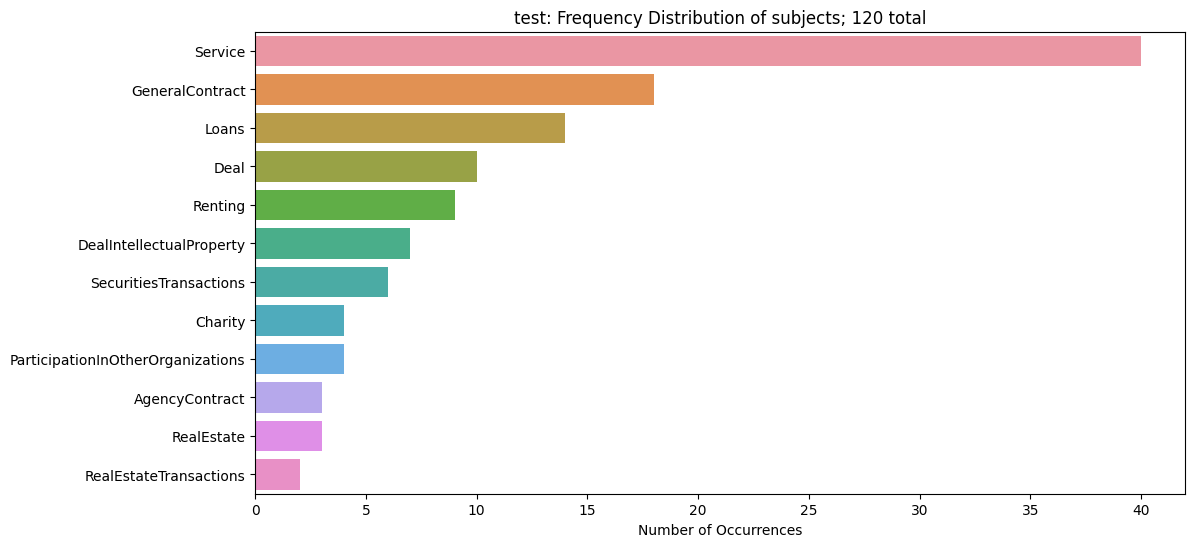

In [34]:


import seaborn as sns
%matplotlib inline
try:
    cnt = userdocs['subject'].value_counts()

    plt.figure(figsize=(12, 6 ))
    sns.barplot(x=cnt.values, y=cnt.index)

    print(  cnt )

    plt.title(f'test: Frequency Distribution of subjects; {len(userdocs)} total')
    plt.xlabel('Number of Occurrences')
    
    _fn = training_reports_path / 'Distribution of subjects -test.png'
    plt.savefig( _fn, bbox_inches='tight', pad_inches=0)
    plt.show()

    mlflow.log_artifact(_fn)


except Exception as e:
    logger.exception(e)

In [35]:

for v in semantic_map_keys:
    for s in ['_expected', '_predicted']:
        userdocs[f'{v}{s}'] = ''
        userdocs[f'{v}{s}'] = userdocs[f'{v}{s}'].astype(str)
        
for v in semantic_keys_numeric:
    for s in ['_expected', '_predicted']:
        userdocs[f'{v}{s}'] = np.NaN
        userdocs[f'{v}{s}'] = userdocs[f'{v}{s}'].astype(float)
        


In [36]:
batch_size = 96
maxlen = 128 * 12


ac = AuditContext()

def interpret_prediction(_id, tagsmap, df):
    col_suffix="_predicted"
    
    doc = load_doc_as_table_row(documents_collection, _id, df)
    if doc is None: 
        return
    
    tokens = doc.get_tokens_map_unchaged()
    
    #---
    # ORGS ------------------
    orgs = nn_find_org_names(tokens, tagsmap, ac)
    if len(orgs)>0:
        o1 = orgs[0]
    else:
        o1={}
        
    if len(orgs)>1:
        o2 = orgs[1]
    else:
        o2={}
        
    for part in ['name', 'alias', 'type']:
        part_tag1 = getattr(o1, part, {})
        part_tag2 = getattr(o2, part, {})
        
        v1 = getattr(part_tag1, 'value', '').lower()
        v2 = getattr(part_tag2, 'value', '').lower()
#         vv= [v1,v2]
        vv=sorted([v1,v2])
        df.at[ _id, f'org-1-{part}{col_suffix}'] = vv[1] 
        df.at[ _id, f'org-2-{part}{col_suffix}'] = vv[0] 
 
    # PRICE ------------------
    cps = nn_find_contract_value(tokens, tagsmap)
    if cps:
        cps=cps[0]
        for v in t_semantic_map_keys_price:
            part = getattr(cps, v)
            if part:
                df.at[ _id, f'{v}{col_suffix}'] = part.value
                 
 
    # DATE NUMBER ------------------
    number_tag = nn_get_contract_number(tokens, tagsmap)
    date_tag =   nn_get_contract_date  (tokens, tagsmap) 
    
        
    if number_tag:
        df.at[ _id, f'number{col_suffix}'] = str(number_tag.value)
    else:
        df.at[ _id, f'number{col_suffix}'] = ''
        
        
    if date_tag:
        df.at[ _id, f'date{col_suffix}'] = str(date_tag.value)
    else:
        df.at[ _id, f'date{col_suffix}'] = ''
 


# Main

In [37]:
validation_set = userdocs

if TEST_FLOW:
    validation_set = userdocs[0:20]
    
predictions_by_id = {}

for i in range(0, len(validation_set), batch_size):
    batch = userdocs[i:i+batch_size]
    actual_batch_size=len(batch)
    print(f'{actual_batch_size=}')
    batch_input_emb=[]
    batch_input_token_f=[]
    for _id in batch.index.values:
 
        dp = make_xyw(_id, userdocs)
        dp = UberModelTrainsetManager.trim_maxlen(dp, 0, maxlen  )
        (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

        batch_input_emb.append(emb)
        batch_input_token_f.append(tok_f)
        
        expected_subj =  decode_subj_prediction(subj)[0]
        userdocs.at[_id, 'subject_expected'] = expected_subj.name
 

    del _id
    del dp

    
    dps =  [np.array(batch_input_emb), np.array(batch_input_token_f)]
 
    
    predictions = umodel.predict(x=dps, batch_size=actual_batch_size)
    del batch_input_emb
    del batch_input_token_f
    
    p_tags = predictions[0]
    p_subj = predictions[1]
    for k,_id in enumerate(batch.index.values):
                   
        tagsmap = pd.DataFrame(p_tags[k], columns=semantic_map_keys_contract)
        interpret_prediction(_id, tagsmap, userdocs)
        predictions_by_id[_id] = tagsmap
        
        subj_1hot = p_subj[k]

        predicted = decode_subj_prediction(subj_1hot)[0]
        userdocs.at[_id, 'subject_predicted'] = predicted.name
        
userdocs[
  ['org-1-type_expected', 'org-1-type_predicted', 'org-1-name_expected', 'org-1-name_predicted', 'org-1-alias_expected', 'org-1-alias_predicted', 
   'org-2-type_expected', 'org-2-type_predicted', 'org-2-name_expected', 'org-2-name_predicted', 'org-2-alias_expected', 'org-2-alias_predicted', 
   'subject_expected', 'subject_predicted', 'date_expected',
   'date_predicted', 'number_expected', 'number_predicted']].head(10)



actual_batch_size=96


2023-04-26 16:34:10.781138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-26 16:34:10.801939: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong cp=<analyser.schemas.ContractPrice object at 0x7ff6f43c37f0>
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 388, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object


actual_batch_size=24


,org-1-type_expected,org-1-type_predicted,org-1-name_expected,org-1-name_predicted,org-1-alias_expected,org-1-alias_predicted,org-2-type_expected,org-2-type_predicted,org-2-name_expected,org-2-name_predicted,org-2-alias_expected,org-2-alias_predicted,subject_expected,subject_predicted,date_expected,date_predicted,number_expected,number_predicted
5ec2b8d8665f7603e03b121f,акционерное общество,акционерное общество,гпн,гпн,продавец,продавец,акционерное общество,акционерное общество,вуз,вуз,покупатель,покупатель,Deal,Deal,2015-02-01 00:00:00,2015-02-01 00:00:00,1658/8549,
5ec2b8d8665f7603e03b1224,общество с ограниченной ответственностью,общество с ограниченной ответственностью,компания,компания,займодавец,займодавец,акционерное общество,акционерное общество,гпн-гпн,гпн-гпн,заемщик,заемщик,Loans,Loans,2014-08-16 00:00:00,2014-08-16 00:00:00,7583-ЗР,
5ec2b8d8665f7603e03b1225,общество с ограниченной ответственностью,общество с ограниченной ответственностью,чудеса,чудеса,исполнитель,исполнитель,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть-корпоративные продажи,газпромнефть-корпоративные продажи,заказчик,заказчик,Charity,Charity,2018-08-25 00:00:00,2018-08-25 00:00:00,КБ 019,
5ec2b8d8665f7603e03b1226,акционерное общество,акционерное общество,ромашка,ромашка,арендодатель,арендодатель,акционерное общество,акционерное общество,гпн-гпн,гпн-гпн,арендатор,арендатор,Renting,Renting,2015-03-01 00:00:00,2015-03-01 00:00:00,_1569/12__,
5ec2b8d8665f7603e03b1229,общество с ограниченной ответственностью,общество с ограниченной ответственностью,радуга,радуга,продавец,продавец,акционерное общество,акционерное общество,мессояханефтегаз,мессояханефтегаз,покупатель,покупатель,RealEstate,RealEstate,2018-03-16 00:00:00,2018-03-16 00:00:00,№6,
5ec2b8d8665f7603e03b122a,общество с ограниченной ответственностью,общество с ограниченной ответственностью,зеленые луга,зеленые луга,исполнитель,исполнитель,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть-корпоративные продажи,газпромнефть-корпоративные продажи,заказчик,заказчик,Charity,Charity,2018-08-25 00:00:00,2018-08-25 00:00:00,КБ 0197531,
5ec2b8d9665f7603e03b1241,общество с ограниченной ответственностью,общество с ограниченной ответственностью,рим,рим,арендодатель,арендодатель,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть,газпром нефть,арендатор,арендатор,Renting,Renting,2015-02-01 00:00:00,2015-02-01 00:00:00,965/03,
5ec2b8d9665f7603e03b1243,общество с ограниченной ответственностью,общество с ограниченной ответственностью,гпн,гпн,арендодатель,арендодатель,общество с ограниченной ответственностью,общество с ограниченной ответственностью,время,,арендатор,арендатор,Renting,Renting,2015-02-01 00:00:00,2015-02-01 00:00:00,321/569,
5ec2b8da665f7603e03b1252,общество с ограниченной ответственностью,общество с ограниченной ответственностью,ромашка,ромашка,продавец,продавец,акционерное общество,акционерное общество,мессояханефтегаз,мессояханефтегаз,покупатель,покупатель,RealEstate,RealEstate,2018-01-01 00:00:00,2018-01-01 00:00:00,4,
5ec2b8da665f7603e03b1256,общество с ограниченной ответственностью,общество с ограниченной ответственностью,комета,комета,займодавец,займодавец,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть шиппинг,газпромнефть шиппинг,заемщик,заемщик,Loans,Loans,2017-06-01 00:00:00,2017-06-01 00:00:00,1598З/859,


## Interpret predictions

In [38]:
_first_id  = list(predictions_by_id.keys())[0]
_first_id
_fp = predictions_by_id[_first_id]
_fp

,headline-begin,headline-end,subject-begin,subject-end,date-begin,date-end,number-begin,number-end,org-name-begin,org-name-end,...,vat-begin,vat-end,sign-begin,sign-end,currency-begin,currency-end,vat_unit-begin,vat_unit-end,value-begin,value-end
0,1.000000,0.013287,0.000713,2.170851e-12,0.007649,0.003241,0.007168,0.027557,0.005397,0.000125,...,1.264238e-07,5.901357e-12,0.004235,1.074142e-05,0.000014,1.348409e-08,2.461460e-06,2.340923e-20,9.424064e-05,0.004445
1,1.000000,0.014216,0.001566,1.398343e-17,0.009270,0.008487,0.010784,0.040579,0.006771,0.000963,...,3.117696e-08,1.981446e-11,0.007377,1.066690e-04,0.000005,4.113426e-09,2.220337e-07,5.822065e-28,8.703147e-06,0.004919
2,1.000000,0.014731,0.000731,6.501762e-13,0.009533,0.011565,0.006512,0.024697,0.005745,0.000006,...,6.348170e-09,8.174837e-19,0.006845,8.796717e-09,0.000002,5.455092e-13,5.200912e-08,2.495344e-34,7.364558e-06,0.005684
3,1.000000,0.015043,0.000722,2.841842e-06,0.006386,0.010823,0.010819,0.022223,0.004344,0.000047,...,1.081388e-11,4.520006e-17,0.003211,3.357217e-07,0.000027,2.168699e-16,6.010293e-09,2.345891e-29,2.333329e-07,0.000298
4,1.000000,0.015524,0.002336,1.575149e-10,0.013222,0.014166,0.011198,0.033769,0.005468,0.000022,...,3.893325e-09,4.007467e-14,0.002993,5.040467e-04,0.000026,1.715751e-10,4.382256e-08,1.079730e-27,2.801349e-07,0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.005515,0.001423,0.002338,3.330767e-03,0.000133,0.001255,0.000638,0.008282,0.003425,0.003917,...,5.187362e-03,5.901217e-03,0.007026,9.304047e-03,0.006236,1.276076e-03,6.704837e-03,6.414771e-03,4.330546e-03,0.006176
1532,0.005471,0.001371,0.002201,3.235966e-03,0.000093,0.001008,0.000564,0.008423,0.003149,0.003980,...,4.930407e-03,5.744427e-03,0.006804,9.294033e-03,0.005971,1.210868e-03,6.287038e-03,6.579757e-03,4.173458e-03,0.005993
1533,0.005440,0.001319,0.002060,3.141910e-03,0.000062,0.000788,0.000490,0.008566,0.002849,0.004020,...,4.648954e-03,5.588710e-03,0.006577,9.283364e-03,0.005684,1.147926e-03,5.874485e-03,6.748974e-03,4.015833e-03,0.005806
1534,0.005433,0.001270,0.001915,3.056079e-03,0.000038,0.000600,0.000417,0.008707,0.002528,0.004025,...,4.345715e-03,5.444020e-03,0.006358,9.273231e-03,0.005379,1.089454e-03,5.482763e-03,6.917655e-03,3.864229e-03,0.005618


In [40]:
def threshold_predictions(p, col_name, threshold):
    p = p.copy()
    p[col_name][p[col_name] > threshold] = 1.0
    p[col_name][p[col_name] < 1] = 0
    return p

# th = _fp.copy()
# threshold = 0.8
# th[th['val'] > threshold] = 1
# th['subject-begin']=th[th['subject-begin']>0.1]


_th = threshold_predictions(_fp, 'date-begin', 0.998)
_df = DataFrame()
interpret_prediction(_first_id, _th, _df)
_df

,number_expected,date_expected,subject_expected,subject,org-1-name_expected,org-2-name_expected,org-1-alias_expected,org-2-alias_expected,org-1-type_expected,org-2-type_expected,...,org-1-alias_predicted,org-2-alias_predicted,org-1-type_predicted,org-2-type_predicted,amount_brutto_predicted,vat_predicted,currency_predicted,vat_unit_predicted,number_predicted,date_predicted
5ec2b8d8665f7603e03b121f,1658/8549,2015-02-01,Deal,Deal,гпн,вуз,продавец,покупатель,акционерное общество,акционерное общество,...,продавец,покупатель,акционерное общество,акционерное общество,65000000.0,65000000.0,RUB,.,,2015-02-01 00:00:00


### Clean predicted/expected values

In [37]:

columns = []
for v in semantic_keys_numeric:
    for s in ['_expected', '_predicted' ]:
        col = f'{v}{s}'
        userdocs[col] = userdocs[col].replace('',np.NaN).replace(np.NaN, -1).astype(int)
        columns.append(col)
        
userdocs['date_predicted'] = userdocs['date_predicted'].astype(str)        
userdocs['date_expected'] = userdocs['date_expected'].astype(str)        
# userdocs[columns]

In [38]:
userdocs=userdocs.replace('None', '')
userdocs=userdocs.replace('none', '')
userdocs=userdocs.replace('nan', '')

userdocs.date_expected =  userdocs.date_expected.replace(np.NaN, '')
userdocs.date_predicted = userdocs.date_predicted.replace(np.NaN, '')

userdocs.number_expected =  userdocs.number_expected.replace(np.NaN, '')
userdocs.number_predicted = userdocs.number_predicted.replace(np.NaN, '')

userdocs.vat_unit_expected =  userdocs.vat_unit_expected.replace(np.NaN, '')
userdocs.vat_unit_predicted = userdocs.vat_unit_predicted.replace(np.NaN, '')

userdocs.vat_expected =  userdocs.vat_expected.replace(np.NaN, '')
userdocs.vat_predicted = userdocs.vat_predicted.replace(np.NaN, '')

userdocs.sign_expected =  userdocs.sign_expected.replace(np.NaN, '')
userdocs.sign_predicted = userdocs.sign_predicted.replace(np.NaN, '')

userdocs.currency_expected =  userdocs.currency_expected.replace(np.NaN, '')
userdocs.currency_predicted = userdocs.currency_predicted.replace(np.NaN, '')

# userdocs[['date_expected', 'date_predicted', 'number_expected', 'number_predicted']]

In [39]:
def select_wrong(userdocs, key):
    s= userdocs[userdocs[f'{key}_expected'] != userdocs[f'{key}_predicted']][[f'{key}_expected', f'{key}_predicted']]
    p=float(len(s)) / len(userdocs)
    return s,p

# Tags report
## accuracy report

In [40]:
userdocs['number_of_errors'] = 0
report = pd.DataFrame()

n   = 0
avg = 0

for k in t_semantic_map_keys_common[1:] + t_semantic_map_keys_price + org_numbered_keys :
    s, p = select_wrong(userdocs, k)
    for _id, _ in s.iterrows():
       userdocs.at[_id, 'number_of_errors'] += 1
    
    acc = 1.0 - p
    report.at[k, 'accuracy']=f"{acc:.1%}"
    mlflow.log_metric(f"accuracy_{k}", acc)
    
    n += 1
    avg += acc
    
avg = avg / n

report.at['ALL', 'accuracy']=f"{avg:.1%}"
mlflow.log_metric("accuracy_TAGS", avg)
report.to_csv(training_reports_path /'attributes_accuracy.csv')    
mlflow.log_artifact(training_reports_path / 'attributes_accuracy.csv')

# 81.6%
report    

,accuracy
subject,0.8%
date,45.8%
number,1.7%
amount,98.3%
amount_brutto,64.2%
amount_netto,37.5%
vat,69.2%
sign,0.0%
currency,27.5%
vat_unit,61.7%


## Worst docs list

In [41]:
userdocs[['number_of_errors']].sort_values('number_of_errors', ascending=False)[:30]

,number_of_errors
6246a1b325a983726c76938a,15
5fe34f64b770574a005553e2,15
6391bbeb1002115a6029f397,15
5ec2b8d8665f7603e03b121f,14
638085666a07f3e980b2c116,14
5ec2b8d8665f7603e03b1229,14
638085676a07f3e980b2c11b,14
638085676a07f3e980b2c11e,14
5fe34f64b770574a005553e6,14
63c506c2e2456d59975e11a3,14


# Subjects predictions reports

In [42]:
ev = userdocs.copy()

In [43]:
subj_pred = ev[pd.notna(ev.subject_predicted)][pd.notna(ev.subject_expected)]
subj_df = subj_pred[['subject_predicted', 'subject_expected']].copy()

In [44]:


labels = sorted(np.unique(subj_df['subject_expected'].values))

In [45]:
report = classification_report(subj_df.subject_expected, subj_df.subject_predicted, digits=3, output_dict=True)
report['weighted avg']
mlflow.log_metrics(report['weighted avg'])
mlflow.log_metric('subject_F1',report['weighted avg']['f1-score'])
mlflow.log_metric('subject_F1_support',report['weighted avg']['support'])
mlflow.log_metric('subject_precision',report['weighted avg']['precision'])
mlflow.log_metric('subject_recall',report['weighted avg']['recall'])

/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/

/root/artem/analyser/colab_support/renderer.py:480: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


make_att_model_03
                                   precision    recall  f1-score   support

                   AgencyContract      0.000     0.000     0.000         3
                          BigDeal      0.000     0.000     0.000         0
                          Charity      0.000     0.000     0.000         4
                             Deal      0.000     0.000     0.000        10
         DealIntellectualProperty      0.000     0.000     0.000         7
                EmployeeContracts      0.000     0.000     0.000         0
                  GeneralContract      0.000     0.000     0.000        18
                        Insurance      0.000     0.000     0.000         0
                      Liquidation      0.000     0.000     0.000         0
                            Loans      0.200     0.071     0.105        14
                            Other      0.000     0.000     0.000         0
ParticipationInOtherOrganizations      0.000     0.000     0.000         4
      

/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/

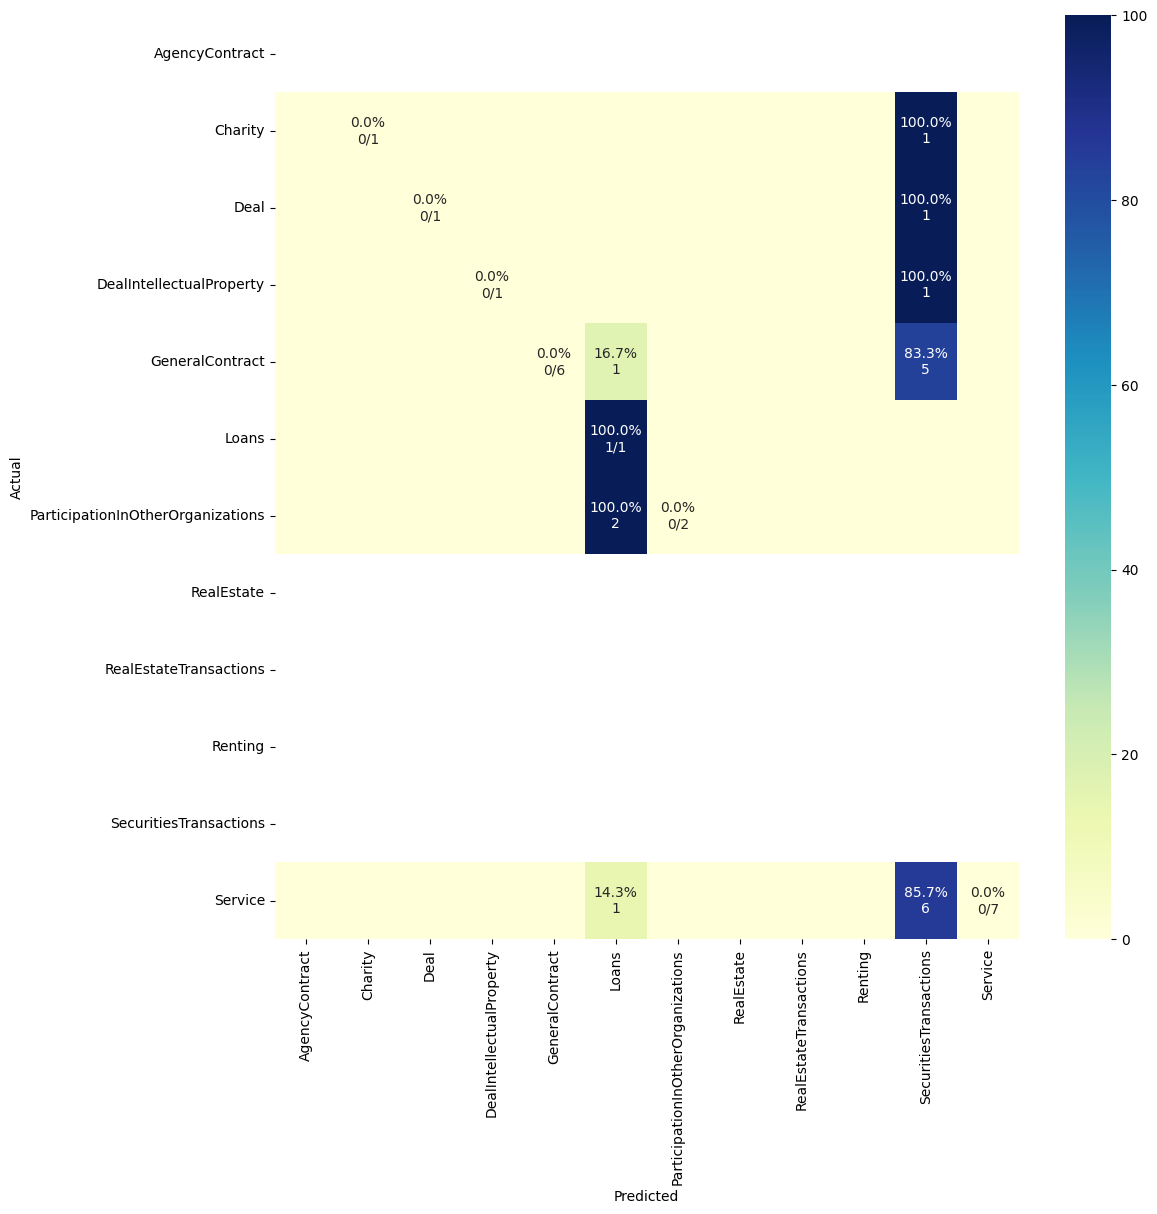

In [46]:


def make_report(umodel, subj_df):
  plot_cm(subj_df.subject_expected.values, subj_df.subject_predicted.values, figsize=(12, 12))
  
  img_path = training_reports_path / f'subjects-confusion-matrix-{umodel.name}.png'
  plt.savefig(img_path, bbox_inches='tight')
  mlflow.log_artifact(img_path)

  report = classification_report(subj_df.subject_expected, subj_df.subject_predicted, digits=3)
  print(umodel.name)
  print(report)

  fn = training_reports_path / f'subjects-classification_report-{umodel.name}.txt'
  with open(fn, "w") as text_file:
    text_file.write(report)
 
  mlflow.log_artifact(fn)


make_report(umodel, subj_df)

In [47]:
if sub_mlflow_run is not None:
    mlflow.end_run()